In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from src.models import *
from axial_attention import AxialAttention
from self_attention_cv import ViT

import pickle

import xarray as xr
import numpy as np
from src.dataloader import *
from src.utils import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'
dl_train = pickle.load(open(DATADRIVE+"saved_datasets/trainloader_single_forecast_only_log_trans_full_padded_24.pkl", "rb"))

# Testing broad field

In [84]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        
        super(SelfAttention, self).__init__()
        self.f = nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8, 
                           kernel_size=1, stride=1, padding=0))
        self.g = nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8, 
                           kernel_size=1, stride=1, padding=0))
        
        self.h= nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=in_channels, 
                           kernel_size=1, stride=1, padding=0))
        
        gamma = torch.tensor(0.0)
        self.gamma = nn.Parameter(gamma, requires_grad=True)
        
        self.flatten = nn.Flatten()
        
    
    def collapse_height_width(self, x):
        x_shape = x.shape
        return torch.reshape(x, (x_shape[0], -1, x.shape[1]))
    
    
    def forward(self, x):
        f = self.f(x)
        g = self.g(x)
        h = self.h(x)
        
        f_flat = self.collapse_height_width(f)
        g_flat = self.collapse_height_width(g)
        h_flat = self.collapse_height_width(h)

#         print(g_flat.shape)
#         print(f_flat.shape)
        s = g_flat @ torch.transpose(f_flat, 1, 2)

#         print(s.shape)
        b = F.softmax(s, dim = -1)
        
        o = b @ h_flat
        
#         print(o.shape)
#         print(x.shape)
        y = self.gamma * torch.reshape(o, x.shape) + x
        
        return y

In [71]:
x, y = next(iter(dl_train))

In [75]:
att = SelfAttention(24)

In [76]:
z = att(x)

RuntimeError: Given groups=1, weight of size [3, 24, 1, 1], expected input[16, 1, 64, 64] to have 24 channels, but got 1 channels instead

In [48]:
64*64

4096

In [85]:
class BroadLeinSAGen(nn.Module):
    def __init__(self):
        super(BroadLeinSAGen, self).__init__()
        self.embed = nn.Conv2d(1,255, kernel_size=3, padding=1)
        self.process = nn.Sequential(LeinResBlock(in_planes=256, planes=256, stride=2,  nonlin = 'relu'), 
                                     LeinResBlock(in_planes=256, planes=256, stride=2, nonlin = 'relu'), 
#                                      LeinResBlock(in_planes=256, planes=256, stride=2, nonlin = 'relu')
                            #         self.b4 = BasicBlock(in_planes=256, planes=256, stride=1, nonlin = 'leaky_relu')
                                        )
        self.upscale = nn.Sequential(LeinResBlock(in_planes=256, planes=256, stride=1,  nonlin = 'leaky_relu'),
                                     UpSample(2, 'bilinear'),
                                     SelfAttention(256),
                                     LeinResBlock(in_planes=256, planes=128, stride=1,  nonlin = 'leaky_relu'),
                                     UpSample(2, 'bilinear'),
                                     LeinResBlock(in_planes=128, planes=64, stride=1,  nonlin = 'leaky_relu'),
                                     UpSample(2, 'bilinear'),
                                     LeinResBlock(in_planes=64, planes=32, stride=1,  nonlin = 'leaky_relu'))
        
        self.final = nn.Conv2d(32,1, kernel_size=3, padding=1)
         
    def forward(self, x, noise):
        x = F.relu(self.embed(x))
        x = torch.cat((x,noise), axis=1)
        x = self.process(x)
#         print(x.shape)
        x = self.upscale(x)
        x = torch.sigmoid(self.final(x))
#         print(x.shape)
        return x
    
    def initialize_weights(self):
        # Initializes weights according to the DCGAN paper
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):#, nn.BatchNorm2d)):
#                 nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.kaiming_normal_(m.weight.data)
            
                                     
class BroadLeinSADisc(nn.Module):
    def __init__(self, nonlin = 'leaky_relu'):
        super(BroadLeinSADisc, self).__init__()
        self.hr_block1 = nn.Sequential(LeinResBlock(in_planes = 1, planes=64, stride=2, nonlin = nonlin), 
                                       LeinResBlock(in_planes = 64, planes=128, stride=2, nonlin = nonlin),
                                       SelfAttention(128),
                                       LeinResBlock(in_planes = 128, planes=256, stride=2, nonlin = nonlin))
        
        self.lr_block1 = nn.Sequential(LeinResBlock(in_planes = 1, planes=64, stride=2, nonlin = nonlin), 
                                       LeinResBlock(in_planes = 64, planes=128, stride=2, nonlin = nonlin),
                                       SelfAttention(128),
                                       LeinResBlock(in_planes = 128, planes=256, stride=1, nonlin = nonlin))
        
        self.hr_block2 = nn.Sequential(LeinResBlock(in_planes=256, planes=256, stride=1, nonlin = nonlin))#, block(in_planes=256, planes=256, stride=1, nonlin = nonlin))
        self.lr_block2 = nn.Sequential(LeinResBlock(in_planes=512, planes=256, stride=1, nonlin = nonlin))#,block(in_planes=256, planes=256, stride=1, nonlin = nonlin))
        self.dense1 = nn.Linear(512, 256)
        self.dense2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity = 'linear')
        self.initialize_weights()
        
        

    def forward(self, X, y):
        hr = self.hr_block1(y)
        lr = self.lr_block1(X)
        lr = torch.cat((lr,hr), axis=1)
        hr = self.hr_block2(hr)
        lr = self.lr_block2(lr)
        hr = nn.AvgPool2d(16)(hr)
        lr = nn.AvgPool2d(16)(lr)
        out = torch.cat((torch.squeeze(hr), torch.squeeze(lr)), axis=1)
        out = F.leaky_relu(self.dense1(out), negative_slope=0.02)
        out = self.dense2(out)
        return out
    
    def initialize_weights(self):
        # Initializes weights according to the DCGAN paper
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):#, nn.BatchNorm2d)):
#                 nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.kaiming_normal_(m.weight.data)





In [86]:
learning_rate = 1e-4
high_res_size = 128
image_channels = 1
noise_shape = (1, 64, 64)
discriminator_features = 64
generator_features = 64
lambda_gp = 10
num_classes = 2
num_embedding_channels = 10


model = LeinGANGP(BroadLeinSAGen, BroadLeinSADisc, 
                  noise_shape, image_channels, 
                  high_res_size, num_embedding_channels, 
                  lr = learning_rate,
                  lambda_gp=lambda_gp, 
                  disc_spectral_norm = False)

torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 128, 128])


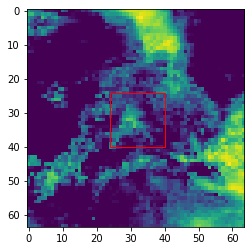

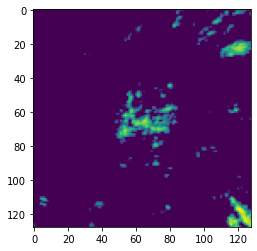

In [87]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots()
x,y = next(iter(dl_train))
print(x.shape)
print(y.shape)
ax.imshow(x[0][0])
rect = patches.Rectangle((24, 24), 16, 16, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
fig, ax = plt.subplots()
ax.imshow(y[0][0])

In [88]:
run_number = 'test'
model_name = 'broadleinsagan'
run_folder = '../models/'+model_name+'/' + run_number

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=run_folder)

trainer = pl.Trainer(gpus = 1, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, dl_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | gen  | BroadLeinSAGen  | 4.2 M 
1 | disc | BroadLeinSADisc | 5.6 M 
-----------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.503    Total estimated model params size (MB)


Epoch 16:  13%|█▎        | 134/1043 [02:10<14:45,  1.03it/s, loss=1.97e+09, v_num=3, discriminator_loss_step=-4.09e+3, generator_loss_step=1.33e+10, discriminator_loss_epoch=-8.87e+5, generator_loss_epoch=8.77e+9]

In [83]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

In [23]:
x = torch.randn(16,128,16,16)
print(x.shape)

torch.Size([16, 128, 16, 16])


In [34]:
attn = AxialAttention(
                    dim=128,
                    dim_index = 1, 
                    dim_heads = 32, 
                    heads = 16,
                    num_dimensions = 2, 
                    sum_axial_out=True)

vit = ViT(img_dim=16, heads = 16, in_channels=1, 
          patch_dim=1, num_classes=10,dim=512, blocks=8)

Epoch 0:   0%|          | 0/1312 [00:27<?, ?it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33af21f550>
Traceback (most recent call last):
  File "/home/ilan/.conda/envs/ilan/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/ilan/.conda/envs/ilan/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ilan/.conda/envs/ilan/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/ilan/.conda/envs/ilan/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/ilan/.conda/envs/ilan/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/ilan/.conda/envs/ilan/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)


In [35]:
out = attn(x)
out.shape

torch.Size([16, 128, 16, 16])

In [38]:
class AxialGenerator(nn.Module):
    def __init__(self, noise_shape, channels_img, features_g, num_classes, img_size, embed_size):
        super(AxialGenerator, self).__init__()
        self.img_size = img_size
        self.embed = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=embed_size, kernel_size=3, padding=1), 
                                   AxialAttention(
                                    dim=embed_size,
                                    dim_index = 1, 
                                    dim_heads = 32, 
                                    heads = 4,
                                    num_dimensions = 2, 
                                    sum_axial_out=True)
                                  )
        self.net = nn.Sequential(
            # Input: N x channels_noise x 16 x 16
            self._block(noise_shape[0] + embed_size, features_g * 16, 1, 1, 0),  # img: 16x16
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 32x32
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 64x64
            nn.ConvTranspose2d(
                features_g * 4, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 128 x 128
            nn.Sigmoid(),
        )
        self.initialize_weights()

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, labels, x):
        embedding  = self.embed(labels)
        x = torch.cat([x, embedding], dim = 1)
        x = self.net(x)
#         print(x.shape)
        return x

    def initialize_weights(self):
        # Initializes weights according to the DCGAN paper
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

In [39]:
LEARNING_RATE = 1e-4
IMG_SIZE = 128
CHANNELS_IMG = 1
NOISE_SHAPE = (1, 16, 16)
FEATURES_CRITIC = 32 #64
FEATURES_GEN = 32 # 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 32

trainer = pl.Trainer(gpus = 1)
model = WGANGP(AxialGenerator, DSDiscriminator, NOISE_SHAPE, CHANNELS_IMG, 
               FEATURES_GEN, NUM_CLASSES, IMG_SIZE, 
               GEN_EMBEDDING, FEATURES_CRITIC, lr = LEARNING_RATE)

trainer.fit(model, dl_train)
        

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | gen  | AxialGenerator  | 2.7 M 
1 | disc | DSDiscriminator | 4.0 M 
-----------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.604    Total estimated model params size (MB)


Epoch 1:  92%|█████████▏| 1209/1312 [24:03<02:03,  1.19s/it, loss=-32.4, v_num=65, discriminator_loss_step=-50.9, generator_loss_step=18.80, discriminator_loss_epoch=-74.7, generator_loss_epoch=66.30]

/home/ilan/.conda/envs/ilan/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [33]:
# trainer = pl.Trainer(gpus = 0)
# trainer.fit(model, dl_train)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type           | Params
----------------------------------------
0 | gen  | AxialAttention | 262 K 
----------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.050     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1312 [00:00<?, ?it/s] 

AssertionError: input tensor does not have the correct input dimension

In [21]:
# import pickle
# pickle.dump(dl_train, open("./dataset/trainloader_single_forecast_only.pkl", "wb"))
# pickle.dump(dl_valid, open("./dataset/validloader_single_forecast_only.pkl", "wb"))

In [ ]:
class MetNetGenerator(nn.Module):
    def __init__(self, noise_shape, channels_img, features_g, num_classes, img_size, embed_size):
        super(DSGenerator, self).__init__()
        self.spatial
        self.embed = nn.Conv2d(in_channels=1, out_channels=embed_size, kernel_size=3, padding=1)
        self.attention = 
        self.net = nn.Sequential(
            # Input: N x channels_noise x 16 x 16
            self._block(noise_shape[0] + embed_size, features_g * 16, 1, 1, 0),  # img: 16x16
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 32x32
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 64x64
            nn.ConvTranspose2d(
                features_g * 4, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 128 x 128
            nn.Sigmoid(),
        )
        self.initialize_weights()

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, labels, x):
        embedding  = self.embed(labels)
        x = torch.cat([x, embedding], dim = 1)
        x = self.net(x)
#         print(x.shape)
        return x

    def initialize_weights(self):
        # Initializes weights according to the DCGAN paper
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)